## Validating Sentinel-1 estimates with key informant data

***About this notebook:*** This code is used to validate the Sentinel-1 derived flooding estimates through a comparison against data collected from key informants through interviews conducted by the Centre for Disaster Protection. We compare flooding estimates from 20 unions in Bangladesh, across 4 different districts: Kurigram, Gaibandha, Sirajganj and Sherpur.

***Inputs:*** 1) .xlsx file with the key informant interview data from the Centre for Disaster Protection and 2) .xlsx file with flood fraction over time.

***Outputs:*** Output figures in the results/plots directory. 

In [9]:
# Import packages
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import os

# Remove default warning message on chained variable assignments
pd.options.mode.chained_assignment = None  

### 1. Read in the data

Read in the two input files, which include flood estimates from Sentinel-1 and from the informant interviews.

In [10]:
interview = pd.read_excel('data/Sentinel-1-BGD-Flooding_INTERVIEW.xlsx', sheet_name='Sheet1_COPY')
updated = pd.read_excel('data/Sentinel-1-BGD-Flooding-updated.xlsx')

### 2. Explore/clean/validate the data

Simple cleaning and manipulation to merge the dataframes, drop unnecessary columns, select data from the unions of interest, and standardize the units for reporting on flood fraction. 

In [11]:
# Drop unnecessary columns
updated = updated.drop(updated.columns[[0,1,2,19]], axis=1)

# Merge flood extent with the interview data 
merged = updated.merge(interview.iloc[:, np.r_[1,7, 15,19:31]], on=['ADM4_EN', 'ADM3_EN','date'], how='left')

# Get list of the unions that have interview data 
sampled_unions = merged.dropna(subset=['Interview_1', 'Interview_2', 'Interview_3'], thresh=1)
sampled_unions_unique = sampled_unions['ADM4_EN'].unique().tolist()

# Get only the data from sampled unions
df = merged[merged['ADM4_EN'].isin(sampled_unions_unique)]

# Normalize the fraction units and convert dates to proper type
df['flood_fraction'] = df['flood_fraction']*100
df['date']= pd.to_datetime(df['date']) 

### 3. Flooding over time across districts from Sentinel-1

Create a simple line plot to show the time series of the flood extent for the five admin-2 districts of interest. This plot shows a clear peak in flooding in late July. 

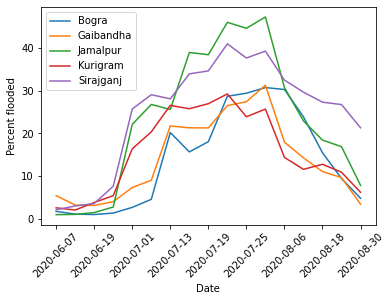

In [4]:
agg = merged
agg['flood_fraction'] = agg['flood_fraction']*100
agg['date'] = pd.to_datetime(agg['date'], format = "%Y-%m-%d").dt.strftime('%Y-%m-%d')
agg = agg.groupby(['date', 'ADM2_EN']).mean().reset_index()
agg = agg.set_index(['date'])
agg.groupby('ADM2_EN')['flood_fraction'].plot(legend=True)
plt.xticks(rotation=45)
plt.ylabel('Percent flooded')
plt.xlabel('Date')

plt.savefig("Results_images/agg.png", bbox_inches='tight', pad_inches=0.2)

### 4. Create figures to compare the Sentinel-1 against interview data

Plots are at the union level (admin-4), showing the flood extent over time from both the interviews and the Sentinel-1 data.

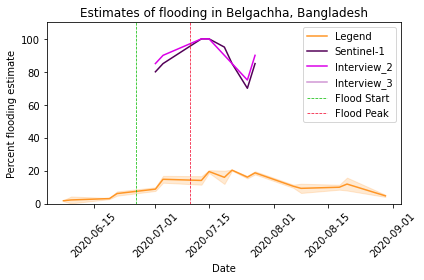

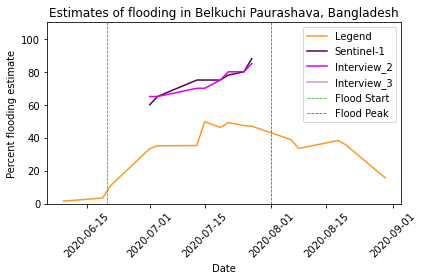

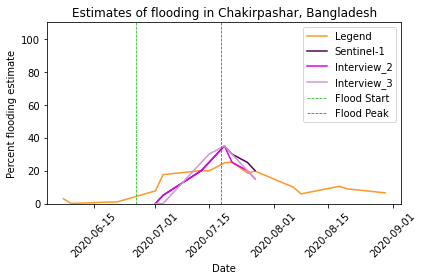

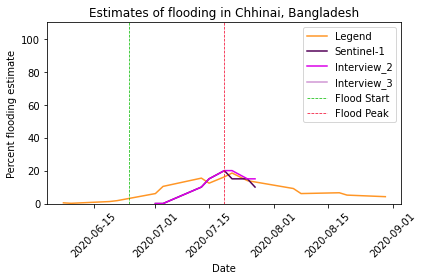

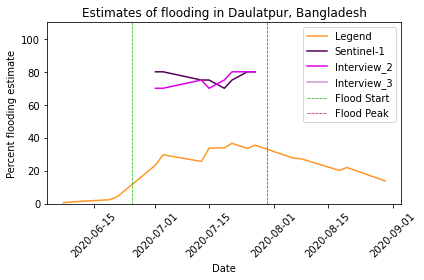

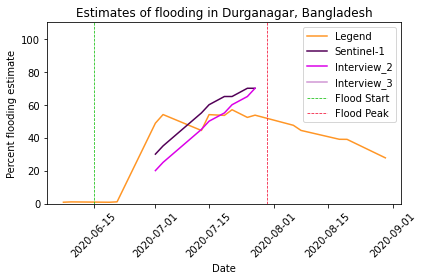

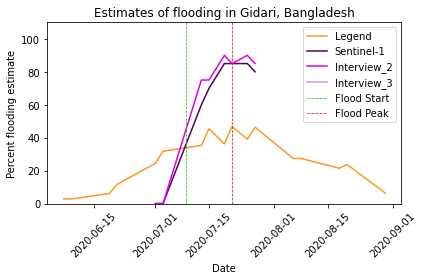

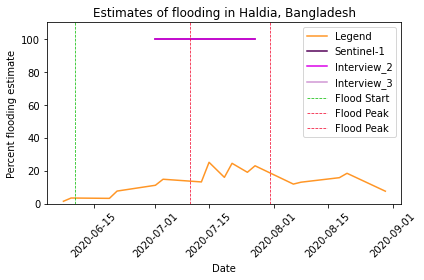

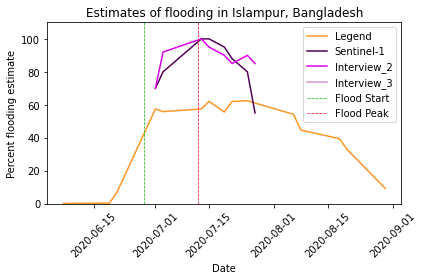

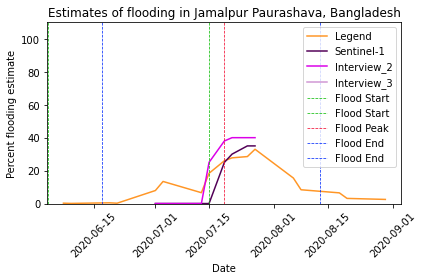

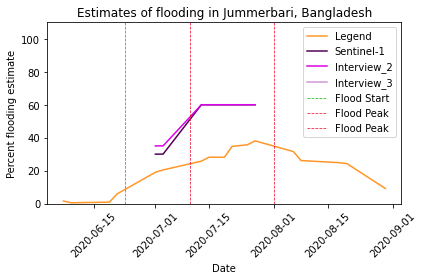

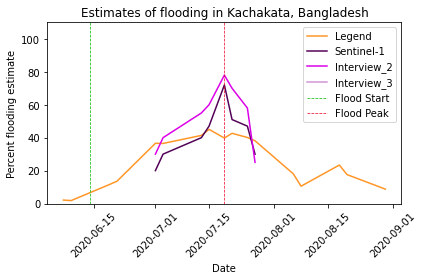

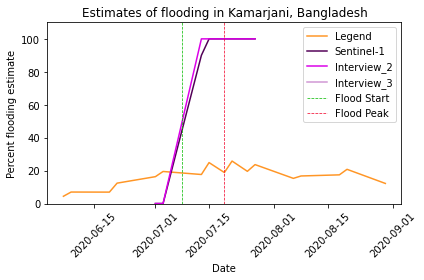

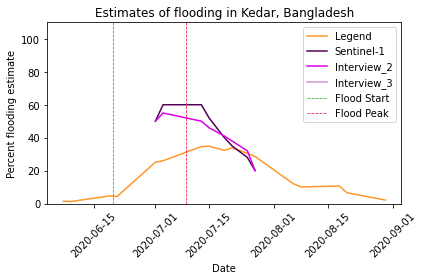

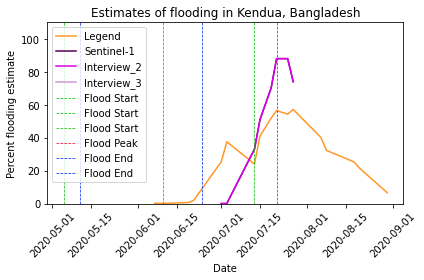

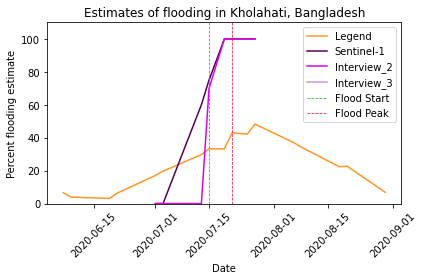

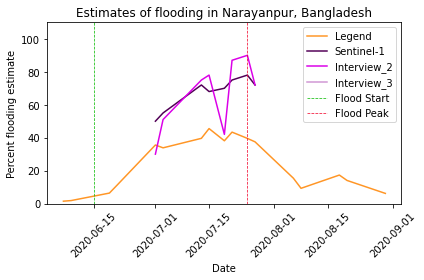

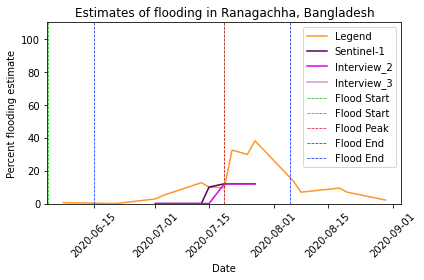

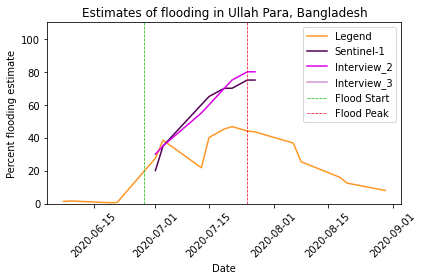

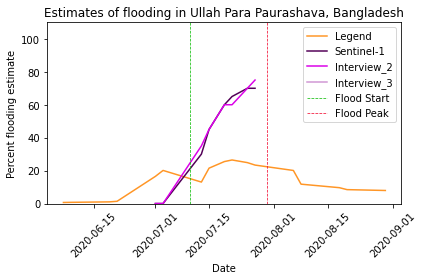

In [10]:
for union in sampled_unions_unique:
    bgd.compare_estimates(df, union)

### 5. Calculate and visualize the daily difference between Sentinel-1 and interviews

In [11]:
# Remove rows without interview data
interviews = df.dropna(subset=['Interview_1', 'Interview_2', 'Interview_3'], thresh=1)

# Select columns of interest from the main dataset and create new dataframe
selected = interviews[['ADM4_EN', 'flood_fraction', 'Interview_1','Interview_2', 'Interview_3', 'date']]

# Get the mean flooding estimates from all the interview data
selected['Interview_Mean'] = selected[['Interview_1','Interview_2', 'Interview_3']].mean(axis=1)

# Calculate the difference from the mean interview data and the Sentinel-1 estimates
selected['Difference'] = selected['Interview_Mean'] - selected['flood_fraction'] 

# Again, select columns of interest for the heatmap
selected = selected[['ADM4_EN', 'date', 'Difference']]

# Probably not the best, but changing type to string simplifies the formatting of the dates in the plot
selected['date'] = selected.date.astype('string')

# Restructure to be suitable for heatmap format
selected_hmap = selected.pivot('ADM4_EN', 'date', 'Difference')

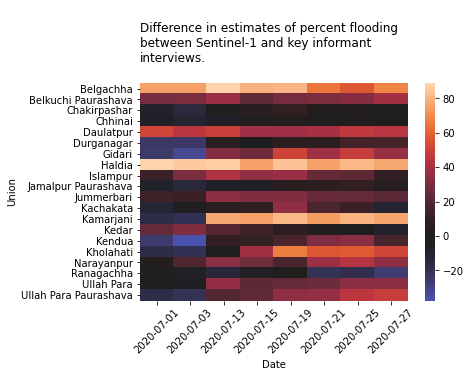

In [12]:
title = """
Difference in estimates of percent flooding 
between Sentinel-1 and key informant 
interviews.
"""

# Create the heatmap, with diverging colour ramp centered on 0 difference
sns.heatmap(selected_hmap, center=0)
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.title(title, loc='left')
plt.ylabel('Union')
#plt.tight_layout()

plt.savefig('Results_images/heatmap.png', bbox_inches='tight', pad_inches=0.2)

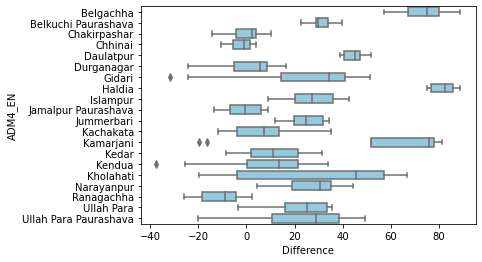

In [13]:
sns.boxplot(x="Difference", y="ADM4_EN", data=selected, color="skyblue")
plt.savefig('Results_images/boxplot.png', bbox_inches='tight', pad_inches=0.2)

### 6. Compare estimates of peak flood dates

In [14]:
# Get sampled unions with only one peak flood date
one_peak = [union for union in sampled_unions_unique if len(bgd.get_dates(df, union, 'pick'))==1]

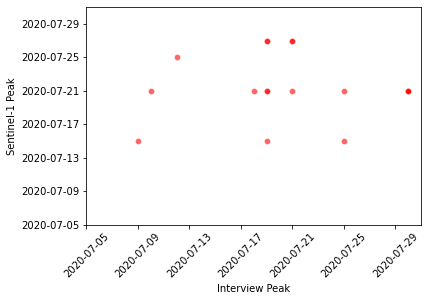

In [15]:
# Sentinel-1 vs interview dates

max_flood = df.loc[df.groupby(['ADM4_EN'])['flood_fraction'].idxmax()]
max_flood = max_flood[['ADM4_EN','flood_fraction','date']]
max_flood['interview'] = [bgd.get_dates(df, union, 'pick')[0] for union in sampled_unions_unique]

max_flood = max_flood[max_flood["ADM4_EN"].isin(one_peak)]

sns.scatterplot(data=max_flood, y="date", x="interview", alpha=0.6, color='red')

plt.ylim([pd.to_datetime('2020-07-05'), pd.to_datetime('2020-07-31')])
plt.xlim([pd.to_datetime('2020-07-05'), pd.to_datetime('2020-07-31')])
plt.xticks(rotation=45)
plt.ylabel('Sentinel-1 Peak')
plt.xlabel('Interview Peak')

plt.savefig("Results_images/s_v_i.png", bbox_inches='tight', pad_inches=0.2)

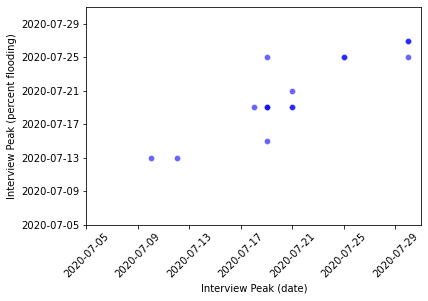

In [16]:
# Interview dates vs interview extent estimates

# Get the mean flooding estimates from all the interview data
df['Interview_Mean'] = df[['Interview_1','Interview_2', 'Interview_3']].mean(axis=1)

max_flood_2 = df.loc[df.groupby(['ADM4_EN'])['Interview_Mean'].idxmax()]
max_flood_2 = max_flood_2[['ADM4_EN','Interview_Mean','date']]
max_flood_2['interview'] = [bgd.get_dates(df, union, 'pick')[0] for union in sampled_unions_unique]

max_flood_2 = max_flood_2[max_flood_2["ADM4_EN"].isin(one_peak)]

sns.scatterplot(data=max_flood_2, y="date", x="interview", alpha=0.6, color='blue')

plt.ylim([pd.to_datetime('2020-07-05'), pd.to_datetime('2020-07-31')])
plt.xlim([pd.to_datetime('2020-07-05'), pd.to_datetime('2020-07-31')])
plt.xticks(rotation=45)
plt.ylabel('Interview Peak (percent flooding)')
plt.xlabel('Interview Peak (date)')

plt.savefig("Results_images/i_v_i.png", bbox_inches='tight', pad_inches=0.2)

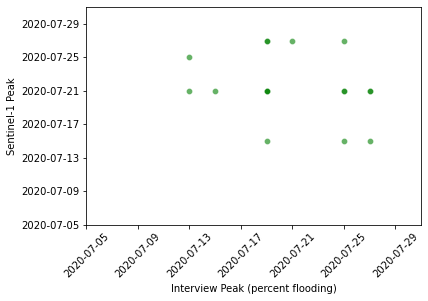

In [17]:
# Interview dates vs interview extent estimates

max_flood_3 = df.loc[df.groupby(['ADM4_EN'])['Interview_Mean'].idxmax()]
max_flood_3 = max_flood_2[['ADM4_EN','Interview_Mean','date']]

max_flood_4 = df.loc[df.groupby(['ADM4_EN'])['flood_fraction'].idxmax()]
max_flood_4 = max_flood_4[['ADM4_EN','flood_fraction','date']]

max_flood_merge = max_flood_3.merge(max_flood_4, on=['ADM4_EN'], how='outer')

max_flood_merge = max_flood_merge[max_flood_merge["ADM4_EN"].isin(one_peak)]

sns.scatterplot(data=max_flood_merge, y="date_y", x="date_x", alpha=0.6, color='green')

plt.ylim([pd.to_datetime('2020-07-05'), pd.to_datetime('2020-07-31')])
plt.xlim([pd.to_datetime('2020-07-05'), pd.to_datetime('2020-07-31')])
plt.xticks(rotation=45)
plt.ylabel('Sentinel-1 Peak')
plt.xlabel('Interview Peak (percent flooding)')

plt.savefig("Results_images/i_v_i_2.png", bbox_inches='tight', pad_inches=0.2)

### 7. Overall takeaways 

* Overall, it appears that the Sentinel-1 __underestimates__ flood extent when compared against the estimates from the key informants. 
* However, there are some cases where the Sentinel-1 estimates are greater than those from the key informants. 
* Surprisingly, the estimates of flood start, peak, and end dates from the informants may not necessarily be aligned with their estimates of the flood extent over time (ie. the flood peak date isn't always the date with the highest flood extent).